In [1]:
import networkx as nx
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.misc.cpg_const as cpg_const
from matching.glema.common.model import InferenceGNN

In [2]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "dpdf"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [3]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/dpdf_undirected_anchored_v2/model.pt ...


In [4]:
def predict( model, G_source, G_query ) -> float:
    p, (x, y) = model.predict( G_source, G_query )
    return p


def is_subgraph( model: InferenceGNN, G_source, G_query, conf=0.5 ) -> bool:
    p, (x, y) = model.predict( G_source, G_query, conf=conf )
    print( f"query is subgraph of source: {x == 1.0} [{p:.3}]" )
    return x == 1.0

In [5]:
record_scopes = graph_utils.get_record_scopes( args )
design_patterns = graph_utils.get_design_patterns( args )
label_args = {
    "record_scopes": record_scopes,
    "design_patterns": design_patterns
}

In [6]:
source_graph_idx = 0
query_subgraph_idx = 5

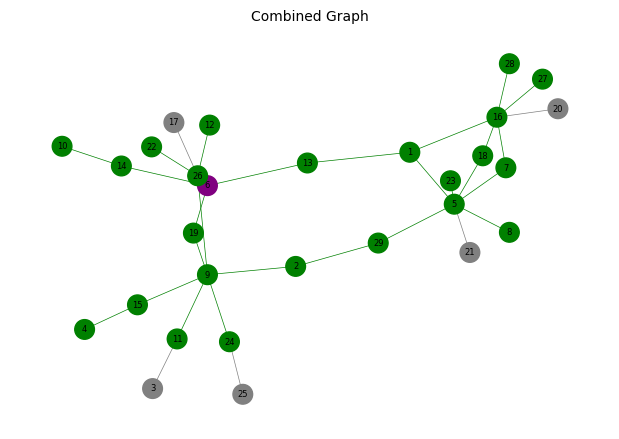

In [7]:
source = graph_utils.load_source_graph( args, source_graph_idx )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx )
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined, node_colors, edge_colors = graph_utils.combine_graph( source, query,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Graph",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    #nodeLabels=graph_utils.get_node_labels( combined, **label_args )
)

In [8]:
is_subgraph( model, source, query )

query is subgraph of source: True [0.983]


True

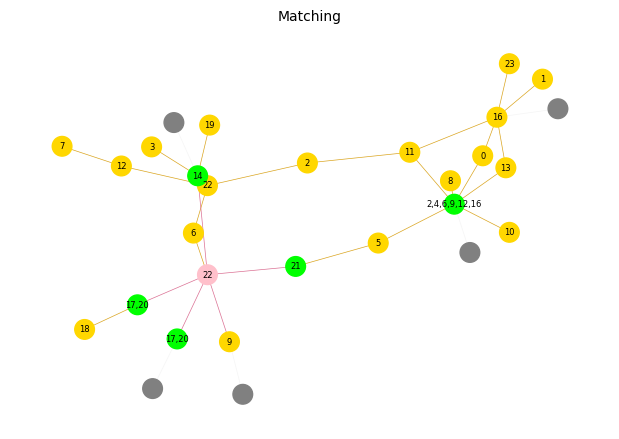

In [12]:
graph_utils.plot_interactions( args, model, source_graph_idx, query_subgraph_idx, threshold=0.5 )

In [16]:
def addCpgNode( G, label: cpg_const.NodeLabel, anchor=False ):
    node_id = G.number_of_nodes()
    anchor_idx = 1 if anchor else 0
    G.add_node( node_id, label=misc_utils.get_enum_idx( label ), anchor=anchor_idx )
    return node_id

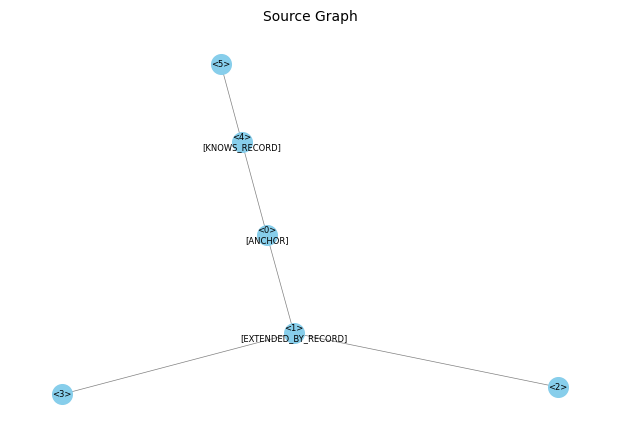

In [17]:
test_source = nx.DiGraph() if args.directed else nx.Graph()
node_a = addCpgNode( test_source, cpg_const.NodeLabel.RECORD, anchor=True )
node_b = addCpgNode( test_source, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
node_c = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
node_d = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
node_e = addCpgNode( test_source, cpg_const.NodeLabel.KNOWS_RECORD )
node_f = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
test_source.add_edge( node_a, node_b )
test_source.add_edge( node_b, node_c )
test_source.add_edge( node_b, node_d )
test_source.add_edge( node_f, node_e )
test_source.add_edge( node_e, node_a )

plot_utils.plot_graph( test_source,
                       title="Source Graph",
                       nodeLabels=graph_utils.get_node_labels( test_source ) )

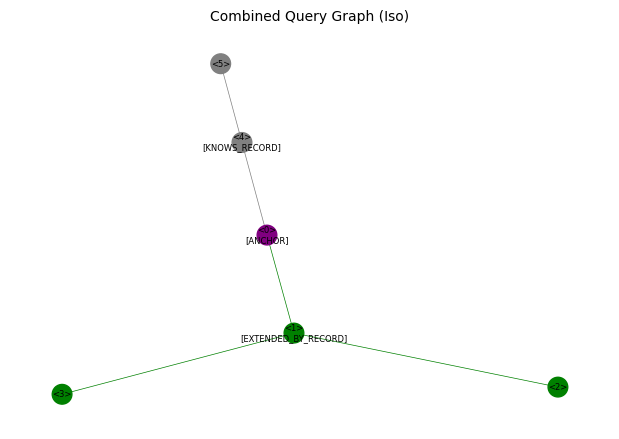

query is subgraph of source: True [0.976]


True

In [18]:
test_query_iso = test_source.copy()
test_query_iso.remove_node( node_e )
test_query_iso.remove_node( node_f )

combined, node_colors, edge_colors = graph_utils.combine_graph( test_source, test_query_iso,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Query Graph (Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)
is_subgraph( model, test_source, test_query_iso )

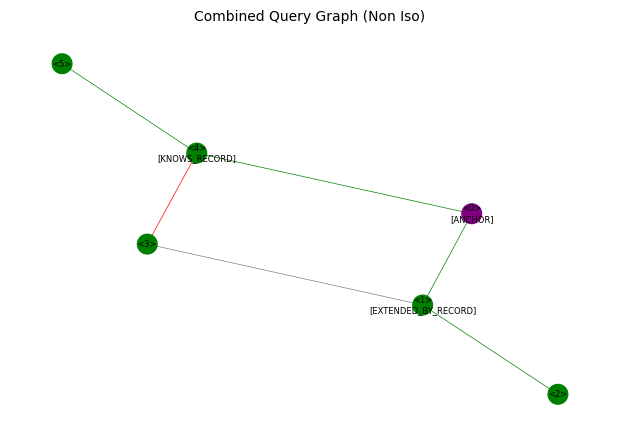

query is subgraph of source: True [0.976]


True

In [19]:
test_query_non_iso = test_source.copy()
test_query_non_iso.remove_edge( node_b, node_d )
test_query_non_iso.add_edge( node_e, node_d )

combined, node_colors, edge_colors = graph_utils.combine_graph( test_source, test_query_non_iso,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Query Graph (Non Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)
is_subgraph( model, test_source, test_query_non_iso )

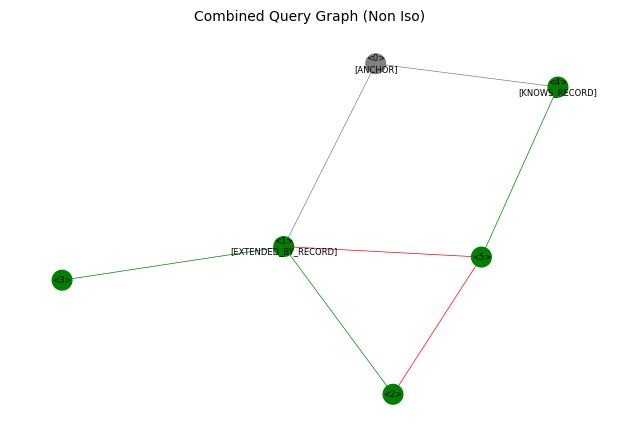

query is subgraph of source: False [0.207]


False

In [20]:
test_query_non_iso = test_source.copy()
test_query_non_iso.remove_node( node_a )
test_query_non_iso.nodes[ node_b ][ "anchored" ] = 1
test_query_non_iso.add_edge( node_f, node_b )
test_query_non_iso.add_edge( node_f, node_c )

combined, node_colors, edge_colors = graph_utils.combine_graph( test_source, test_query_non_iso,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Query Graph (Non Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)
is_subgraph( model, test_source, test_query_non_iso )

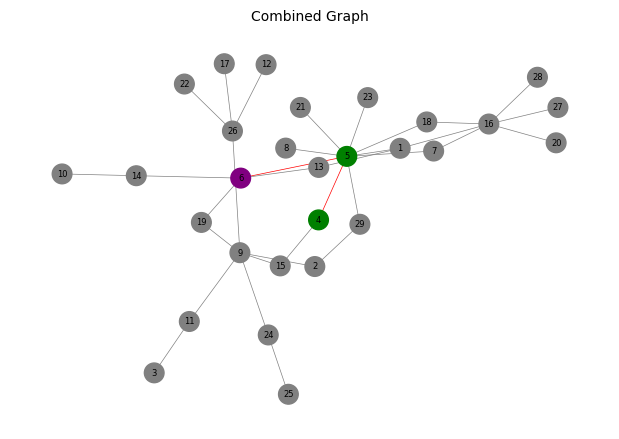

query is subgraph of source: False [0.00415]


False

In [21]:
args.test_data = True
args.iso = False
source_graph_idx = 0
query_subgraph_idx = 6
source = graph_utils.load_source_graph( args, source_graph_idx )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx )
combined, node_colors, edge_colors = graph_utils.combine_graph( source, query,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Graph",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors
)
is_subgraph( model, source, query )

In [22]:
args.test_data = True
source_graph_idx = 0
conf = 0.5 

sources = []
queries = []
y = []

for iso in [True, False]:
    args.iso = iso
    source = graph_utils.load_source_graph( args, source_graph_idx )
    queries.extend( [ *graph_utils.load_query_graphs( args, source_graph_idx ).values() ] )
    sources.extend( [ source for _ in list( range( len( queries ) ) ) ] )
    y.extend( [ (1.0 if iso else 0.0) for _ in list( range( len( queries ) ) ) ] )

preds, (x, y) = model.predict_batch( sources, queries, y_labels=y, conf=conf )
for idx, pred in enumerate( preds ):
    is_correct = int( x[ idx ] ) == int( y[ idx ] )
    print( f"Sample {idx}: x/y=[{is_correct}] [p={pred:.3}]" )

Sample 0: x/y=[True] [p=0.914]
Sample 1: x/y=[True] [p=0.99]
Sample 2: x/y=[True] [p=0.99]
Sample 3: x/y=[True] [p=0.964]
Sample 4: x/y=[True] [p=0.985]
Sample 5: x/y=[True] [p=0.981]
Sample 6: x/y=[True] [p=0.988]
Sample 7: x/y=[True] [p=0.988]
Sample 8: x/y=[True] [p=0.985]
Sample 9: x/y=[True] [p=0.978]
Sample 10: x/y=[True] [p=0.988]
Sample 11: x/y=[True] [p=0.988]
Sample 12: x/y=[True] [p=0.967]
Sample 13: x/y=[True] [p=0.971]
Sample 14: x/y=[True] [p=0.914]
Sample 15: x/y=[True] [p=0.989]
Sample 16: x/y=[True] [p=0.987]
Sample 17: x/y=[True] [p=0.988]
Sample 18: x/y=[True] [p=0.979]
Sample 19: x/y=[True] [p=0.988]
Sample 20: x/y=[True] [p=0.989]
Sample 21: x/y=[True] [p=0.589]
Sample 22: x/y=[True] [p=0.985]
Sample 23: x/y=[True] [p=0.987]
Sample 24: x/y=[True] [p=0.988]
Sample 25: x/y=[True] [p=0.989]
Sample 26: x/y=[True] [p=0.989]
Sample 27: x/y=[True] [p=0.988]
Sample 28: x/y=[True] [p=0.978]
Sample 29: x/y=[True] [p=0.985]
Sample 30: x/y=[True] [p=0.99]
Sample 31: x/y=[True]

Roc=[1.0] Acc=[1.0] Prec=[1.0] Rec=[1.0] F1=[1.0] AvgPrec=[1.0] Var=[0.23] Std=[0.48]


(array([0, 1]), [Text(0, 0, 'True'), Text(0, 1, 'False')])

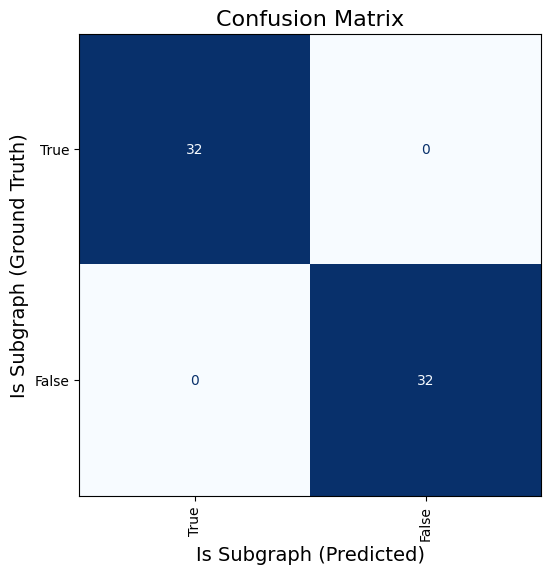

In [23]:
p_roc = roc_auc_score( y, x )
p_acc = accuracy_score( y, x )
p_pre = precision_score( y, x, zero_division=np.nan )
p_rec = recall_score( y, x, zero_division=np.nan )
p_f1s = f1_score( y, x, zero_division=np.nan )
p_prc = average_precision_score( y, x )
p_var = np.var( preds )
p_std = np.std( preds )

print( f"Roc=[{p_roc:.3}] Acc=[{p_acc:.3}]"
       f" Prec=[{p_pre:.3}] Rec=[{p_rec:.3}] F1=[{p_f1s:.3}]"
       f" AvgPrec=[{p_prc:.3}] Var=[{p_var:.3}] Std=[{p_std:.3}]" )

labels = [ True, False ]
x_labels = [ True if v == 1.0 else False for v in x ]
y_labels = [ True if v == 1.0 else False for v in y ]
cm = confusion_matrix( y_labels, x_labels, labels=labels )
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=labels )
fig, ax = plt.subplots( figsize=(6, 6) )  # Set figure size
disp.plot( cmap=plt.cm.Blues, ax=ax, colorbar=False )

plt.title( "Confusion Matrix", fontsize=16 )
plt.xlabel( "Is Subgraph (Predicted)", fontsize=14 )
plt.ylabel( "Is Subgraph (Ground Truth)", fontsize=14 )
plt.xticks( fontsize=10, rotation=90 )
plt.yticks( fontsize=10 )